In [ ]:
!pip install datasets

In [ ]:
# Step 0: Install NLTK in your Colab environment if you haven't already.
# Run this in a separate cell or at the very top of your script once per session:
# !pip install nltk datasets scikit-learn networkx wordcloud matplotlib seaborn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk # Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams # For n-gram generation
from nltk.sentiment.vader import SentimentIntensityAnalyzer # For Sentiment Analysis
from wordcloud import WordCloud # For generating word clouds
import re # Regular expressions for text cleaning
from datasets import load_dataset # Added for Hugging Face datasets

# For Topic Modeling and Advanced N-grams (TF-IDF)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# For Network Analysis
import networkx as nx

# --- Setup and Configuration ---

# Download necessary NLTK data
print("--- Checking and Downloading NLTK Resources ---")
nltk_resources_to_download = ['vader_lexicon', 'punkt', 'stopwords'] # 'punkt_tab' is not standard

for resource_name in nltk_resources_to_download:
    try:
        print(f"Attempting to ensure NLTK resource '{resource_name}' is available...")
        nltk.download(resource_name, quiet=False)
        print(f"NLTK resource '{resource_name}' is available or was downloaded.")
    except ValueError as ve:
        print(f"ValueError downloading NLTK resource '{resource_name}': {ve}")
    except Exception as e:
        print(f"Could not download or verify NLTK resource '{resource_name}'. Error: {e}")
print("--- NLTK Resource Check Complete ---")


# Set style for plots for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12


# --- Load Data ---
expected_column_names = [
    'id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title',
    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'
]
label_mapping_hf = {0: 'false', 1: 'half-true', 2: 'mostly-true', 3: 'true', 4: 'barely-true', 5: 'pants-fire'}

dfs = {} # Dictionary to hold train, test, valid dataframes

try:
    print("Attempting to load LIAR dataset from Hugging Face...")
    liar_dataset_dict = load_dataset("liar")

    for split_name in ['train', 'test', 'validation']:
        print(f"Processing {split_name} split...")
        df_hf = liar_dataset_dict[split_name].to_pandas()

        column_mapping_hf = {
            'id': 'id', 'label': 'label', 'statement': 'statement', 'subject': 'subject',
            'speaker': 'speaker', 'job_title': 'speaker_job_title', 'state_info': 'state_info',
            'party_affiliation': 'party_affiliation', 'barely_true_counts': 'barely_true_counts',
            'false_counts': 'false_counts', 'half_true_counts': 'half_true_counts',
            'mostly_true_counts': 'mostly_true_counts', 'pants_on_fire_counts': 'pants_on_fire_counts',
            'context': 'context'
        }
        df_current_split = df_hf.rename(columns=column_mapping_hf)
        df_current_split['label'] = df_current_split['label'].map(label_mapping_hf)

        for col_name in expected_column_names:
            if col_name not in df_current_split.columns:
                df_current_split[col_name] = 0.0 if 'counts' in col_name else "Unknown"
        dfs[split_name] = df_current_split[expected_column_names].copy() # Store a copy
    print("LIAR dataset splits (train, test, validation) loaded successfully from Hugging Face.")

except Exception as e:
    print(f"ERROR: Could not load LIAR dataset from Hugging Face. Error: {e}")
    print("Falling back to dummy data for demonstration.")






--- Checking and Downloading NLTK Resources ---
Attempting to ensure NLTK resource 'vader_lexicon' is available...
NLTK resource 'vader_lexicon' is available or was downloaded.
Attempting to ensure NLTK resource 'punkt' is available...
NLTK resource 'punkt' is available or was downloaded.
Attempting to ensure NLTK resource 'stopwords' is available...
NLTK resource 'stopwords' is available or was downloaded.
--- NLTK Resource Check Complete ---
Attempting to load LIAR dataset from Hugging Face...


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Processing train split...
Processing test split...
Processing validation split...
LIAR dataset splits (train, test, validation) loaded successfully from Hugging Face.


In [ ]:
# --- Basic Sanity Checks on Loaded Data Splits ---
print("\n--- Basic Sanity Checks on Loaded Data Splits ---")
count_cols = ['barely_true_counts', 'false_counts', 'half_true_counts',
              'mostly_true_counts', 'pants_on_fire_counts'] # Define once for use in sanity checks

for split_name, temp_df in dfs.items():
    print(f"\n--- Sanity Check for: {split_name.upper()} SET ---")
    print(f"Shape: {temp_df.shape}")

    print(f"\nFirst 3 rows of {split_name.upper()} SET:") # Display sample data
    print(temp_df.head(5))

    print("\nInfo:")
    temp_df.info()

    print("\nMissing Values per Column:")
    missing_values = temp_df.isnull().sum()
    if missing_values.sum() == 0:
        print("No missing values found in this split.")
    else:
        print(missing_values[missing_values > 0])

    print("\nDuplicate Rows:")
    duplicates = temp_df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates}")

    print("\nLabel Distribution (Proportions):")
    if 'label' in temp_df.columns and not temp_df['label'].empty:
        print(temp_df['label'].value_counts(normalize=True).sort_index())
    else:
        print("'label' column not found or is empty.")

    print("\nNumerical Columns (Counts) Sanity:")
    for col in count_cols:
        if col in temp_df.columns:
            # Ensure column is numeric before checks
            current_col_data = pd.to_numeric(temp_df[col], errors='coerce').fillna(0)
            if (current_col_data < 0).any():
                print(f"Warning: Negative values found in '{col}' column for {split_name} set.")
            # print(f"Basic stats for '{col}': Min={current_col_data.min()}, Max={current_col_data.max()}, Mean={current_col_data.mean():.2f}")
        else:
            print(f"Count column '{col}' not found in {split_name} set.")
    print(f"--- End of Sanity Check for: {split_name.upper()} SET ---")


# For the rest of the detailed EDA, we'll primarily use the training set.
df = dfs['train'].copy() # Main DataFrame for detailed EDA




--- Basic Sanity Checks on Loaded Data Splits ---

--- Sanity Check for: TRAIN SET ---
Shape: (10269, 14)

First 3 rows of TRAIN SET:
           id        label                                          statement                             subject         speaker     speaker_job_title state_info party_affiliation  barely_true_counts  false_counts  half_true_counts  mostly_true_counts  pants_on_fire_counts              context
0   2635.json        false  Says the Annies List political group supports ...                            abortion    dwayne-bohac  State representative      Texas        republican                 0.0           1.0               0.0                 0.0                   0.0             a mailer
1  10540.json    half-true  When did the decline of coal start? It started...  energy,history,job-accomplishments  scott-surovell        State delegate   Virginia          democrat                 0.0           0.0               1.0                 1.0                   0.

In [ ]:
df.head()

id        label                                          statement                             subject         speaker     speaker_job_title state_info party_affiliation  barely_true_counts  false_counts  half_true_counts  mostly_true_counts  pants_on_fire_counts              context
0   2635.json        false  Says the Annies List political group supports ...                            abortion    dwayne-bohac  State representative      Texas        republican                 0.0           1.0               0.0                 0.0                   0.0             a mailer
1  10540.json    half-true  When did the decline of coal start? It started...  energy,history,job-accomplishments  scott-surovell        State delegate   Virginia          democrat                 0.0           0.0               1.0                 1.0                   0.0      a floor speech.
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...                      foreign-policy    barack-obama             President   Illinois          democrat                70.0          71.0             160.0               163.0                   9.0               Denver
3   1123.json        false  Health care reform legislation is likely to ma...                         health-care    blog-posting                                               none                 7.0          19.0               3.0                 5.0                  44.0       a news release
4   9028.json    half-true  The economic turnaround started at the end of ...                        economy,jobs   charlie-crist                          Florida          democrat                15.0           9.0              20.0                19.0                   2.0  an interview on CNN

In [ ]:
dfs['test'].head()

id       label                                          statement                                            subject                           speaker     speaker_job_title state_info party_affiliation  barely_true_counts  false_counts  half_true_counts  mostly_true_counts  pants_on_fire_counts                       context
0  11972.json        true  Building a wall on the U.S.-Mexico border will...                                        immigration                        rick-perry              Governor      Texas        republican                30.0          30.0              42.0                23.0                  18.0               Radio interview
1  11685.json       false  Wisconsin is on pace to double the number of l...                                               jobs                 katrina-shankland  State representative  Wisconsin          democrat                 2.0           1.0               0.0                 0.0                   0.0             a news conference
2  11096.json       false  Says John McCain has done nothing to help the ...                    military,veterans,voting-record                      donald-trump       President-Elect   New York        republican                63.0         114.0              51.0                37.0                  61.0  comments on ABC's This Week.
3   5209.json   half-true  Suzanne Bonamici supports a plan that will cut...  medicare,message-machine-2012,campaign-adverti...                     rob-cornilles            consultant     Oregon        republican                 1.0           1.0               3.0                 1.0                   1.0                  a radio show
4   9524.json  pants-fire  When asked by a reporter whether hes at the ce...  campaign-finance,legal-issues,campaign-adverti...  state-democratic-party-wisconsin                        Wisconsin          democrat                 5.0           7.0               2.0                 2.0                   7.0                   a web video

In [ ]:
dfs['validation'].head()

id        label                                          statement                           subject          speaker                              speaker_job_title state_info party_affiliation  barely_true_counts  false_counts  half_true_counts  mostly_true_counts  pants_on_fire_counts                        context
0  12134.json  barely-true  We have less Americans working now than in the...                      economy,jobs   vicky-hartzler                            U.S. Representative   Missouri        republican                 1.0           0.0               1.0                 0.0                   0.0   an interview with ABC17 News
1    238.json   pants-fire  When Obama was sworn into office, he DID NOT u...  obama-birth-certificate,religion      chain-email                                                                        none                11.0          43.0               8.0                 5.0                 105.0                               
2   7891.json        false  Says Having organizations parading as being so...   campaign-finance,congress,taxes  earl-blumenauer                            U.S. representative     Oregon          democrat                 0.0           1.0               1.0                 1.0                   0.0  a U.S. Ways and Means hearing
3   8169.json    half-true     Says nearly half of Oregons children are poor.                           poverty  jim-francesconi  Member of the State Board of Higher Education     Oregon              none                 0.0           1.0               1.0                 1.0                   0.0             an opinion article
4    929.json    half-true  On attacks by Republicans that various program...                  economy,stimulus     barack-obama                                      President   Illinois          democrat                70.0          71.0             160.0               163.0                   9.0        interview with CBS News


--- Data Cleaning (on Training Set Copy for Detailed EDA) ---

Missing values after cleaning (Training Set Copy for Detailed EDA):
 0  total missing values.


<ipython-input-53-ccbd05bcd44a>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)



--- EDA Section 1: Cross-Split Basic Comparison (Plots) ---


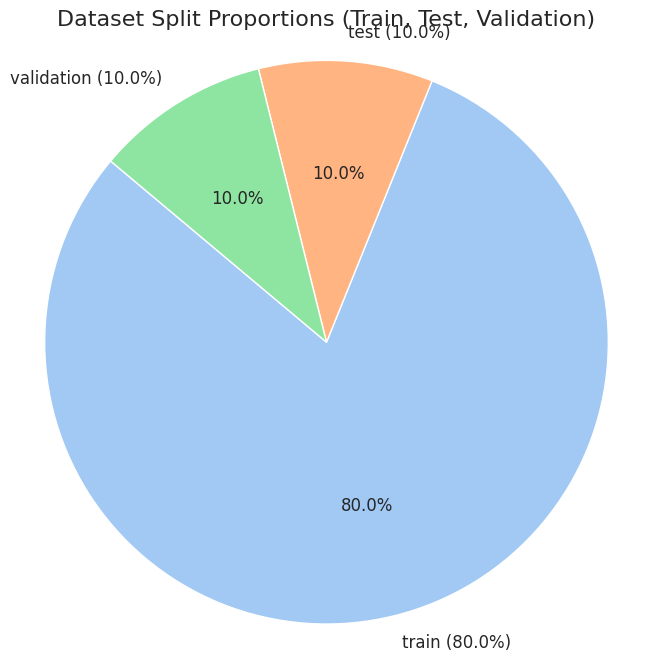


Dataset Split Sizes:
Train set: 10269 samples (80.0%)
Test set: 1283 samples (10.0%)
Validation set: 1284 samples (10.0%)


<ipython-input-53-ccbd05bcd44a>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts_split.index, y=label_counts_split.values, palette="coolwarm", order=label_order)
<ipython-input-53-ccbd05bcd44a>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts_split.index, y=label_counts_split.values, palette="coolwarm", order=label_order)
<ipython-input-53-ccbd05bcd44a>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts_split.index, y=label_counts_split.values, palette="coolwarm", order=label_order)


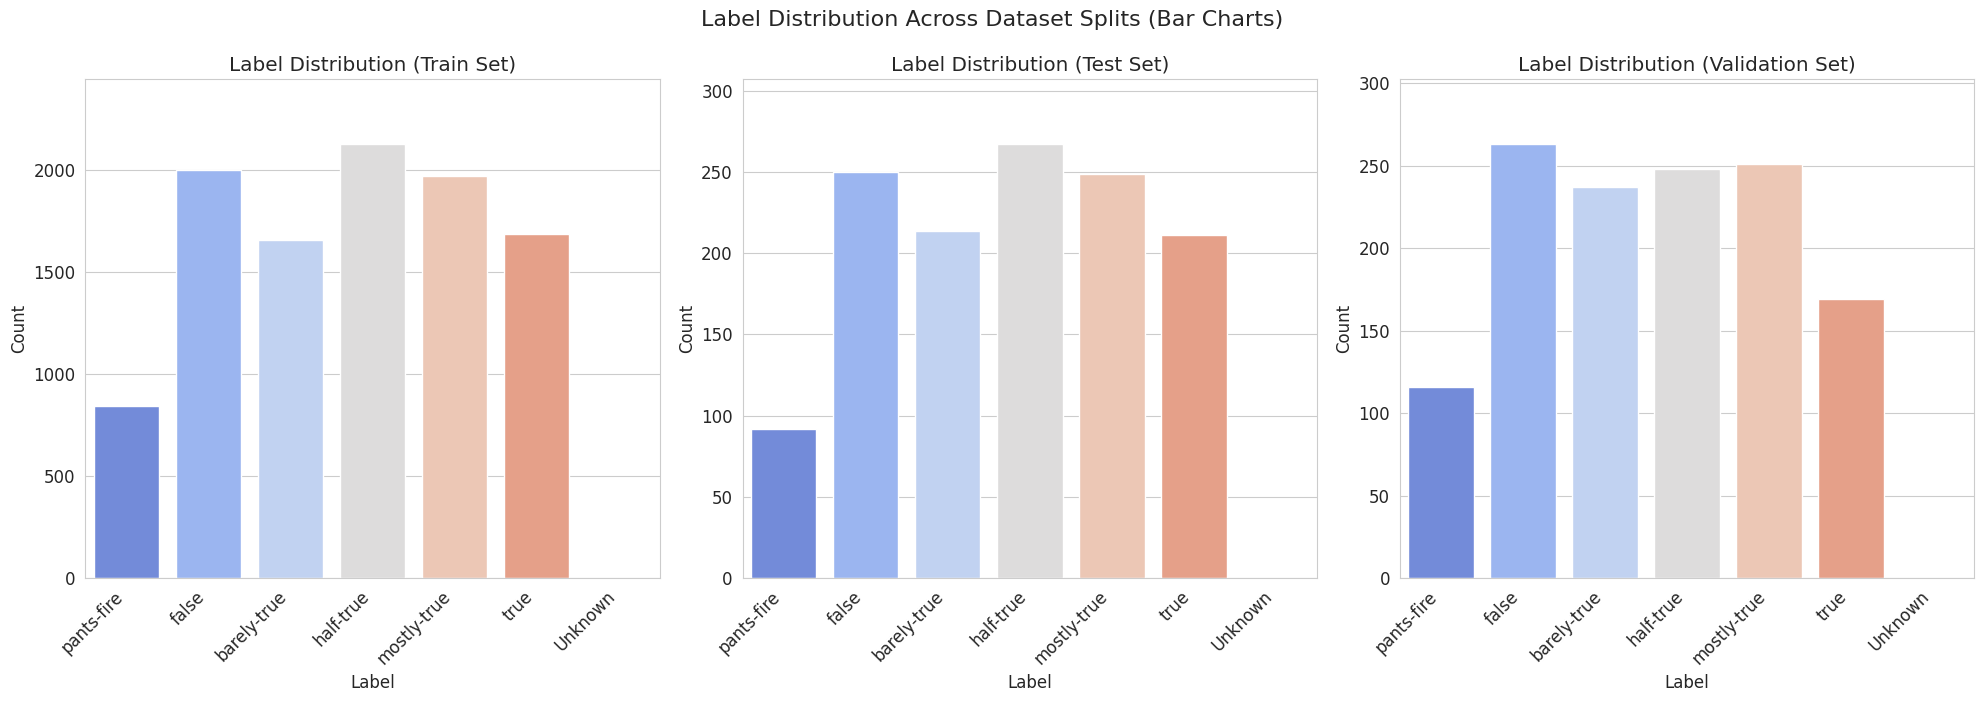

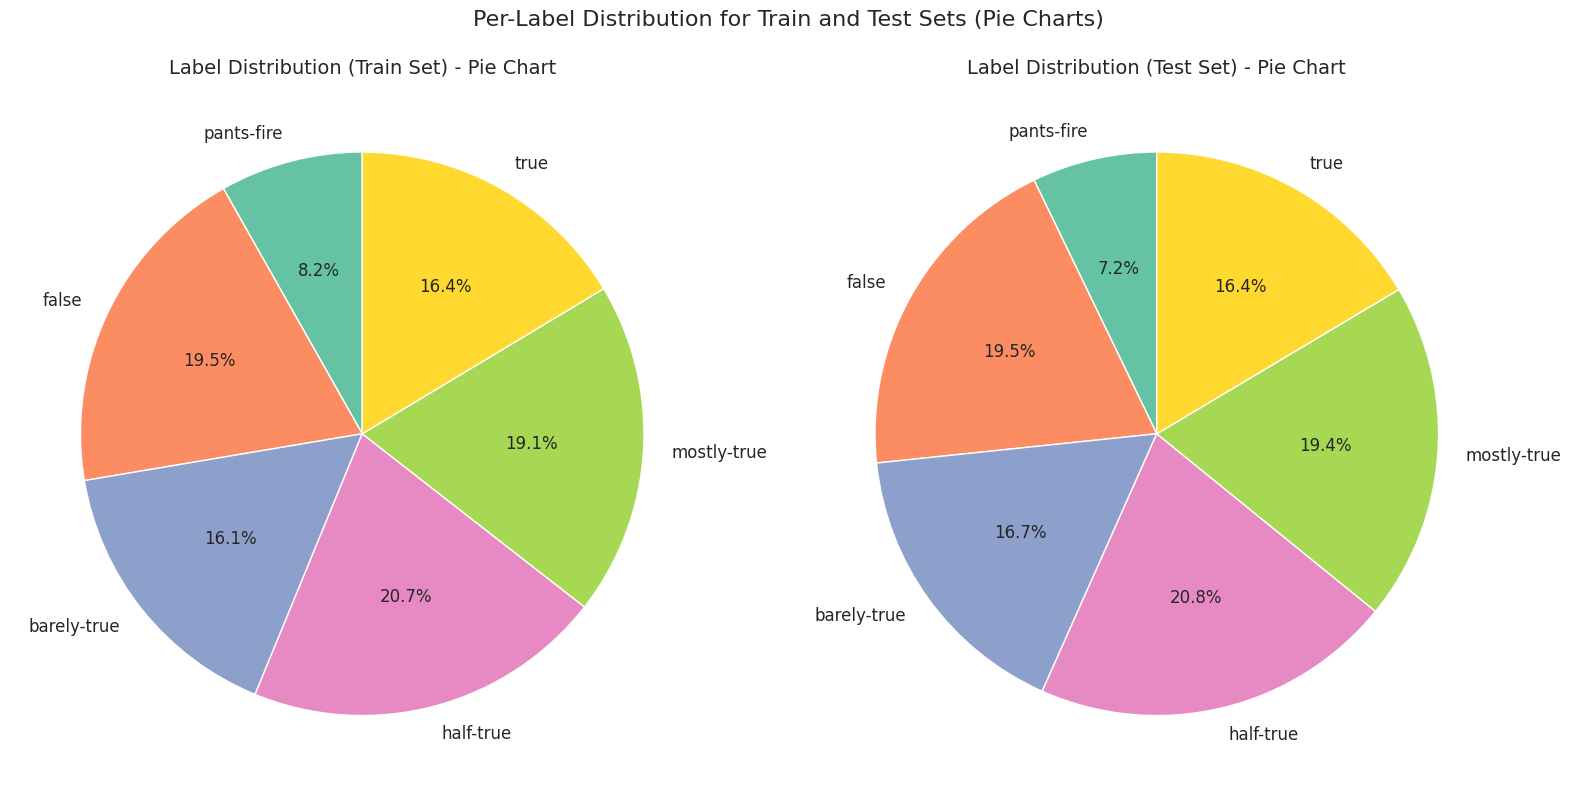

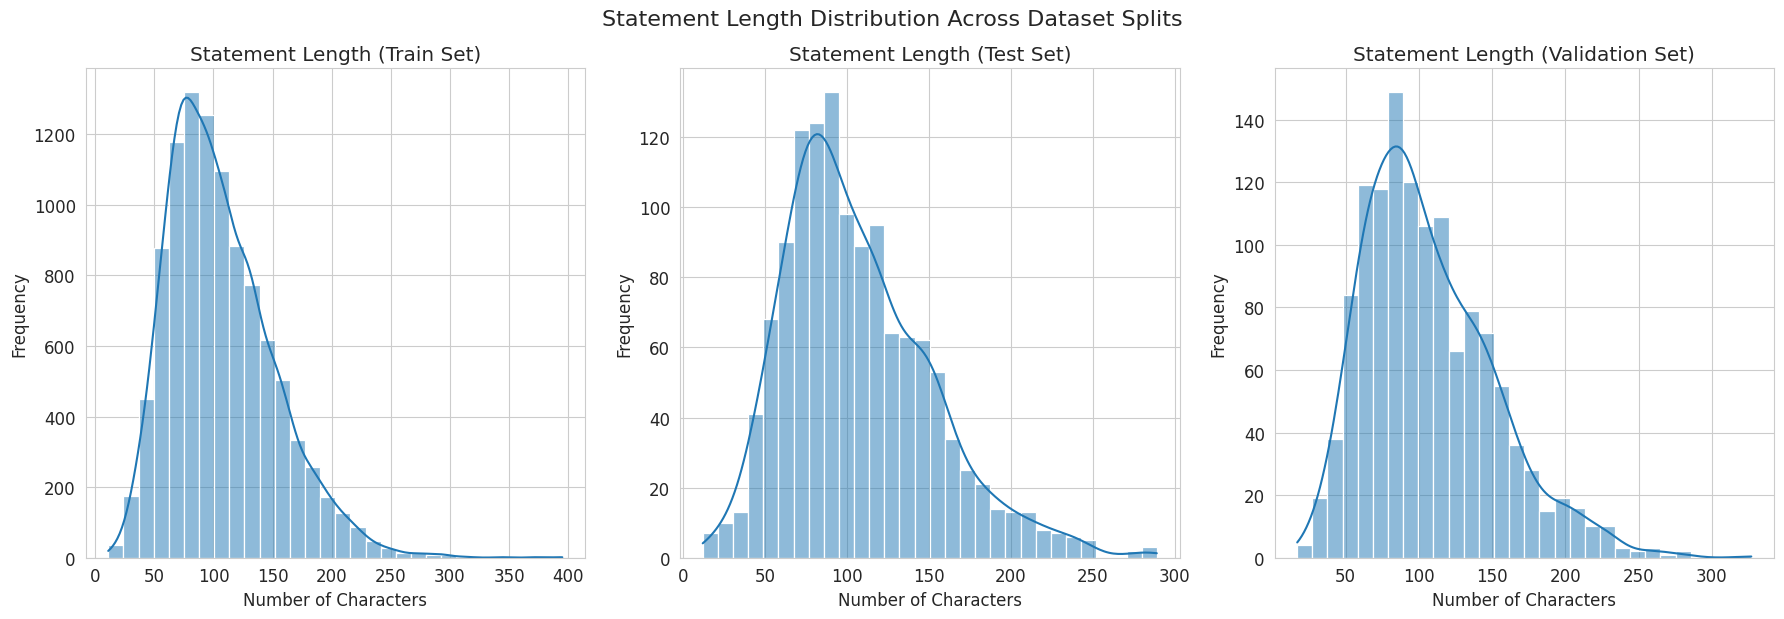

In [ ]:
# --- Data Cleaning (Applied to the main 'df' (training set copy) ---
print("\n--- Data Cleaning (on Training Set Copy for Detailed EDA) ---")
# count_cols already defined
for col in count_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

categorical_cols_to_fill = ['subject', 'speaker', 'speaker_job_title', 'state_info', 'party_affiliation', 'context']
for col in categorical_cols_to_fill:
    df[col].fillna('Unknown', inplace=True)
if df['statement'].isnull().any():
    df['statement'].fillna('', inplace=True)
if df['label'].isnull().any():
    df['label'].fillna('Unknown', inplace=True)
print("\nMissing values after cleaning (Training Set Copy for Detailed EDA):\n", df.isnull().sum().sum(), " total missing values.")

duplicate_rows = df.duplicated().sum()
if duplicate_rows > 0:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates dropped from training set copy. New shape: {df.shape}")

def preprocess_text_eda(text, remove_stopwords_flag=False):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\n', ' ', text)
    text = text.strip()
    if remove_stopwords_flag:
        try:
            stop_words_set = set(stopwords.words('english'))
            word_tokens = word_tokenize(text)
            filtered_text = [word for word in word_tokens if word.isalpha() and word not in stop_words_set]
            return " ".join(filtered_text)
        except Exception as e:
            word_tokens = text.split()
            basic_stopwords = set(["a", "an", "the", "is", "are"])
            filtered_text = [word for word in word_tokens if word.isalpha() and word not in basic_stopwords]
            return " ".join(filtered_text)
    return text

df['statement_cleaned_stopwords_removed'] = df['statement'].apply(lambda x: preprocess_text_eda(x, remove_stopwords_flag=True))
df['statement_cleaned_keep_stopwords'] = df['statement'].apply(lambda x: preprocess_text_eda(x, remove_stopwords_flag=False))



# --- EDA Section 1: Cross-Split Basic Comparison (Plots) ---
print("\n--- EDA Section 1: Cross-Split Basic Comparison (Plots) ---")
label_order = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true', 'Unknown']

# 1.1 Pie Chart for Data Split Sizes
split_sizes = {name: len(d) for name, d in dfs.items()}
total_size = sum(split_sizes.values()) if sum(split_sizes.values()) > 0 else 1 # Avoid division by zero
split_percentages = {name: (size / total_size) * 100 for name, size in split_sizes.items()}

plt.figure(figsize=(8, 8))
# Ensure there are values to plot
if split_percentages and any(v > 0 for v in split_percentages.values()):
    plt.pie(split_percentages.values(), labels=[f'{k} ({v:.1f}%)' for k,v in split_percentages.items()],
            autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
    plt.title('Dataset Split Proportions (Train, Test, Validation)', fontsize=16)
    plt.axis('equal')
    plt.show()
else:
    print("No data in `dfs` or all splits are empty, cannot plot split proportions pie chart.")

print("\nDataset Split Sizes:")
for name, size in split_sizes.items():
    print(f"{name.capitalize()} set: {size} samples ({split_percentages.get(name, 0):.1f}%)")


# 1.2 Bar Chart for Label Distribution Across Splits
plt.figure(figsize=(20, 7))
for i, (split_name, split_df_orig) in enumerate(dfs.items()):
    split_df = split_df_orig.copy()
    split_df['label'] = pd.Categorical(split_df['label'], categories=label_order, ordered=True)

    plt.subplot(1, 3, i + 1)
    label_counts_split = split_df['label'].value_counts().sort_index()
    sns.barplot(x=label_counts_split.index, y=label_counts_split.values, palette="coolwarm", order=label_order)
    plt.title(f'Label Distribution ({split_name.capitalize()} Set)')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    if not label_counts_split.empty:
        plt.ylim(0, label_counts_split.max() * 1.15)
    else:
        plt.ylim(0, 10)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Label Distribution Across Dataset Splits (Bar Charts)', fontsize=16, y=1.0)
plt.show()

# 1.3 Pie Charts for Per-Label Distribution (Train and Test sets)
splits_for_pie = {'train': dfs.get('train', pd.DataFrame()), 'test': dfs.get('test', pd.DataFrame())}

plt.figure(figsize=(16, 8))
plot_index = 1
for split_name, temp_df_orig in splits_for_pie.items():
    if temp_df_orig.empty:
        print(f"Skipping pie chart for empty {split_name} set.")
        continue
    temp_df = temp_df_orig.copy()
    temp_df['label'] = pd.Categorical(temp_df['label'], categories=label_order, ordered=True)
    label_counts_pie = temp_df['label'].value_counts().sort_index()
    label_counts_pie = label_counts_pie[label_counts_pie > 0]

    if not label_counts_pie.empty:
        plt.subplot(1, 2, plot_index)
        plt.pie(label_counts_pie.values, labels=label_counts_pie.index, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette("Set2", len(label_counts_pie)))
        plt.title(f'Label Distribution ({split_name.capitalize()} Set) - Pie Chart', fontsize=14)
        plot_index += 1
    else:
        print(f"No data to plot pie chart for {split_name} set labels.")
plt.tight_layout()
plt.suptitle('Per-Label Distribution for Train and Test Sets (Pie Charts)', fontsize=16, y=1.03)
if plot_index > 1 : plt.show()


# 1.4 Statement Length Distribution Across Splits
plt.figure(figsize=(18, 6))
for i, (split_name, split_df_orig) in enumerate(dfs.items()):
    if split_df_orig.empty:
        print(f"Skipping statement length plot for empty {split_name} set.")
        continue
    split_df = split_df_orig.copy()
    split_df['statement_length_comp'] = split_df['statement'].apply(lambda x: len(str(x)))
    plt.subplot(1, 3, i + 1)
    sns.histplot(split_df['statement_length_comp'], bins=30, kde=True)
    plt.title(f'Statement Length ({split_name.capitalize()} Set)')
    plt.xlabel('Number of Characters')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.suptitle('Statement Length Distribution Across Dataset Splits', fontsize=16, y=1.03)
plt.show()






--- EDA Section 2: Detailed EDA on Training Set ---


<ipython-input-55-10a95ea37d46>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='statement_word_count', data=df, order=label_order, palette="coolwarm")


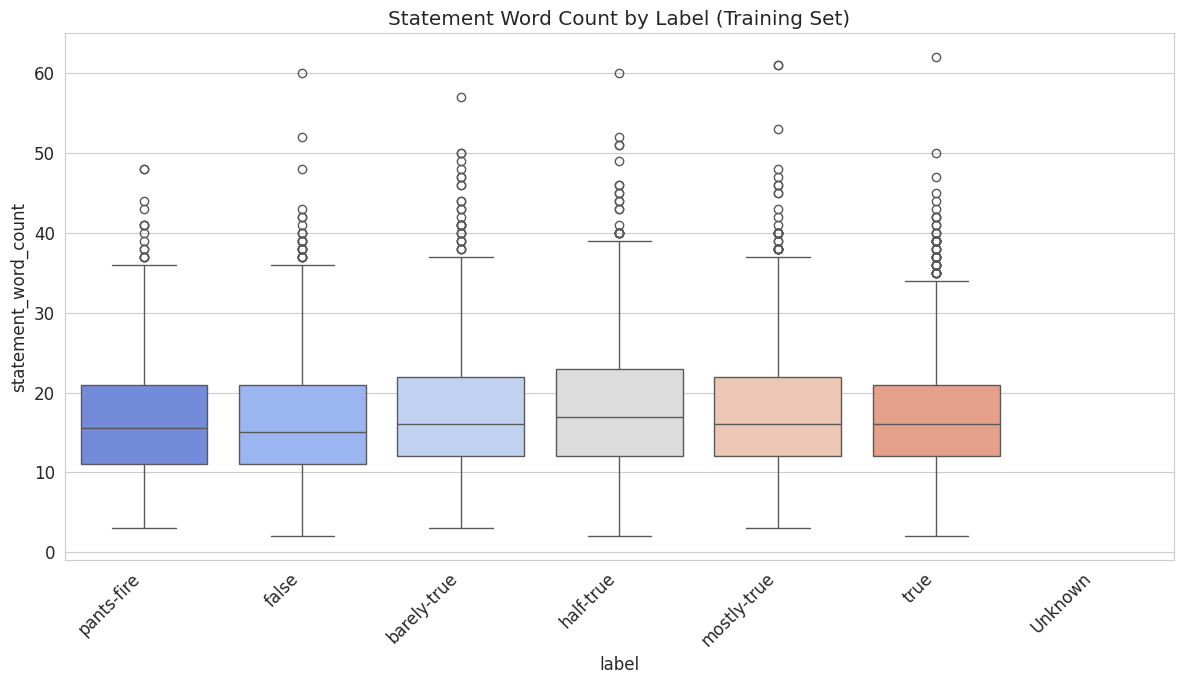

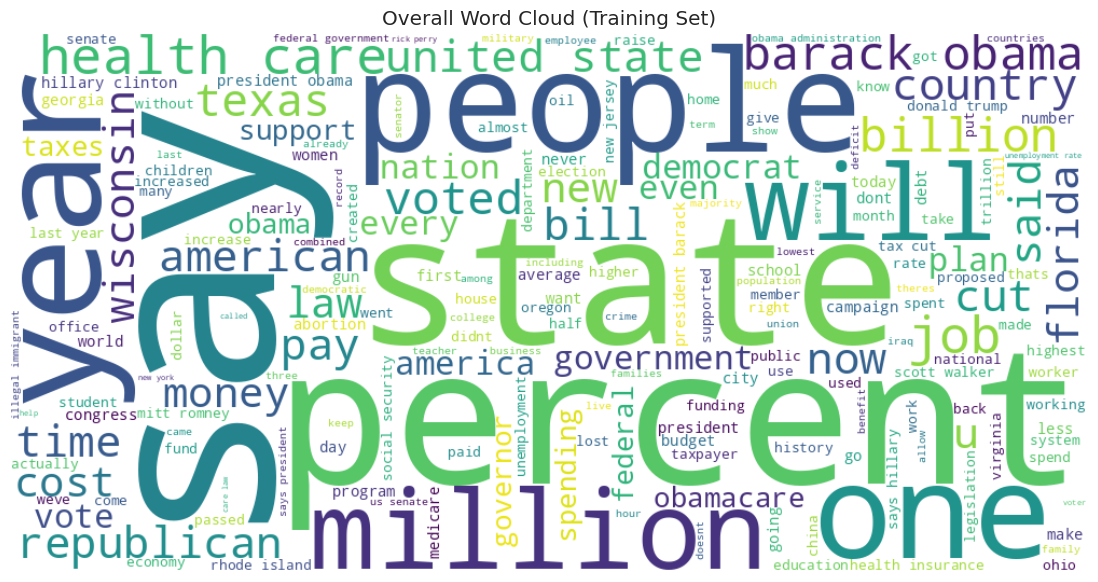


Generating Word Clouds per Label (Training Set)...


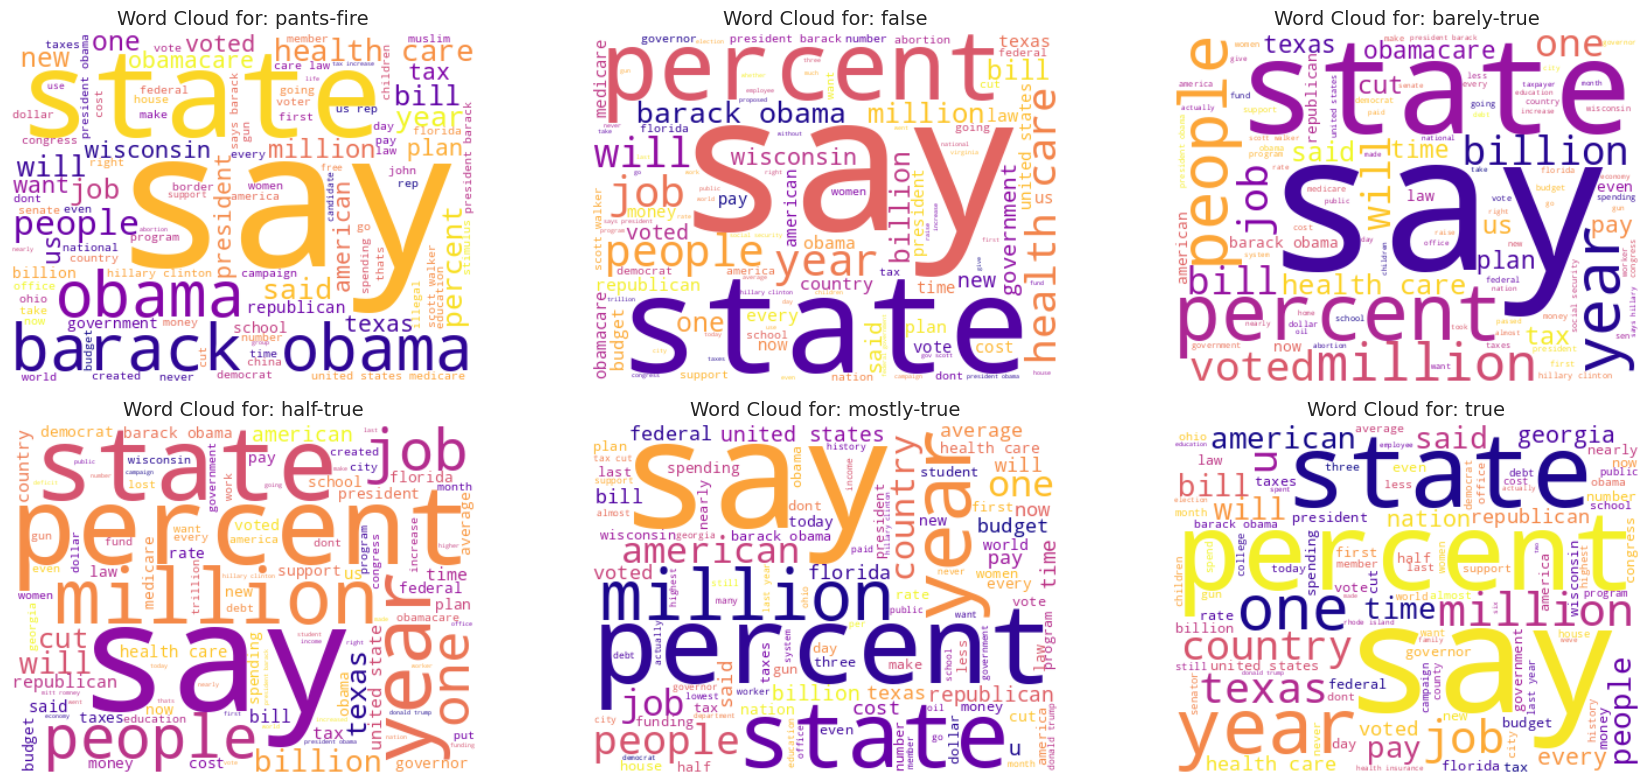

In [ ]:
if not df.empty:
    print("\n--- EDA Section 2: Detailed EDA on Training Set ---")
    df['label'] = pd.Categorical(df['label'], categories=label_order, ordered=True)
    df['statement_length'] = df['statement_cleaned_keep_stopwords'].apply(len)
    df['statement_word_count'] = df['statement_cleaned_keep_stopwords'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='label', y='statement_word_count', data=df, order=label_order, palette="coolwarm")
    plt.title('Statement Word Count by Label (Training Set)'); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

    all_statements_for_wc = ' '.join(df['statement_cleaned_stopwords_removed'].dropna())
    if all_statements_for_wc:
        wordcloud_overall = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(all_statements_for_wc)
        plt.figure(figsize=(15, 7))
        plt.imshow(wordcloud_overall, interpolation='bilinear'); plt.axis('off'); plt.title('Overall Word Cloud (Training Set)'); plt.show()
    else:
        print("No text for overall word cloud in training set.")

    # Word clouds per label
    print("\nGenerating Word Clouds per Label (Training Set)...")
    # Determine number of rows/cols for subplots dynamically
    num_labels_to_plot = df['label'].nunique()
    if 'Unknown' in df['label'].unique() and df['label'].value_counts()['Unknown'] == 0 : # if Unknown exists but has no data
        num_labels_to_plot = max(1, num_labels_to_plot -1)

    if num_labels_to_plot > 0:
        cols_subplot = 3
        rows_subplot = (num_labels_to_plot + cols_subplot - 1) // cols_subplot # Ceiling division
        fig, axes = plt.subplots(rows_subplot, cols_subplot, figsize=(cols_subplot*6, rows_subplot*4))
        axes = axes.ravel() # Flatten for easy iteration

        plot_idx = 0
        for label_val in df['label'].cat.categories:
            if label_val == 'Unknown' and df['label'].value_counts().get(label_val, 0) == 0:
                continue # Skip 'Unknown' if it has no instances
            if plot_idx >= len(axes): break # Safety break

            label_text = ' '.join(df[df['label'] == label_val]['statement_cleaned_stopwords_removed'].dropna())
            ax = axes[plot_idx]
            if label_text:
                try:
                    wordcloud_label = WordCloud(width=400, height=300, background_color='white', colormap='plasma',
                                                max_words=100, contour_width=1, contour_color='steelblue').generate(label_text)
                    ax.imshow(wordcloud_label, interpolation='bilinear')
                    ax.set_title(f'Word Cloud for: {label_val}', fontsize=14)
                except ValueError: # Handle cases where generate fails (e.g. empty string after filtering)
                     ax.text(0.5, 0.5, 'Not enough words', ha='center', va='center', transform=ax.transAxes)
                     ax.set_title(f'Word Cloud for: {label_val} (Error)', fontsize=14)
            else:
                ax.text(0.5, 0.5, 'No statements', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'Word Cloud for: {label_val} (No Data)', fontsize=14)
            ax.axis('off')
            plot_idx +=1

        # Hide any unused subplots
        for i in range(plot_idx, len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.show()
    else:
        print("No labels with data to generate per-label word clouds.")



--- EDA Section 3: Advanced N-gram Analysis (TF-IDF) on Training Set ---


<ipython-input-57-0aaaa79173ca>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plt.figure(figsize=(10, 8)); sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_unigrams_overall, palette='summer'); plt.title('Top 15 TF-IDF Unigrams (Overall)'); plt.show()


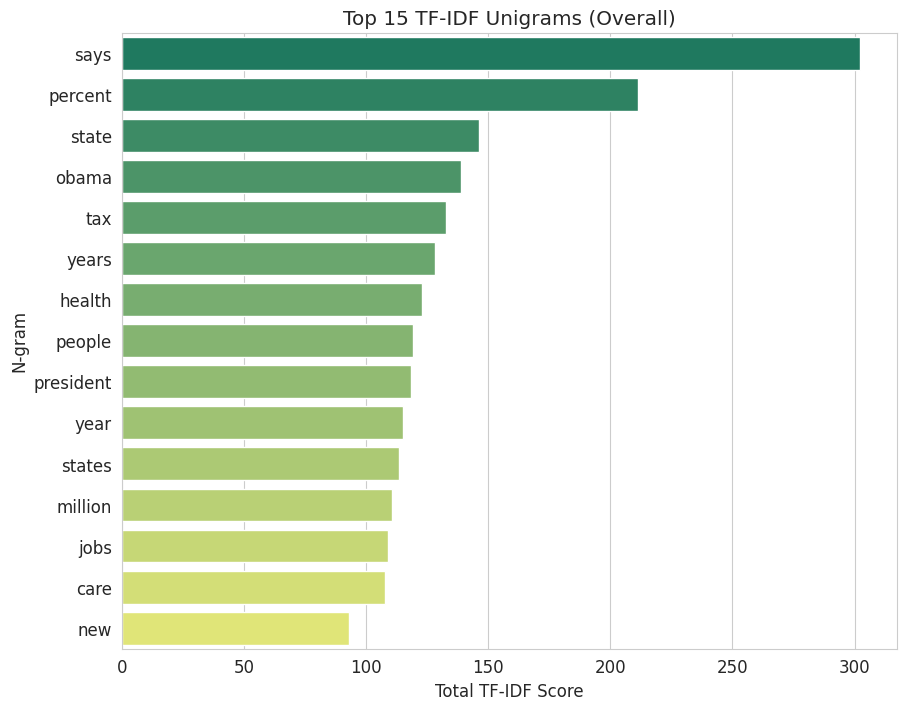

<ipython-input-57-0aaaa79173ca>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plt.figure(figsize=(10, 8)); sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_bigrams_overall, palette='autumn'); plt.title('Top 15 TF-IDF Bigrams (Overall)'); plt.show()


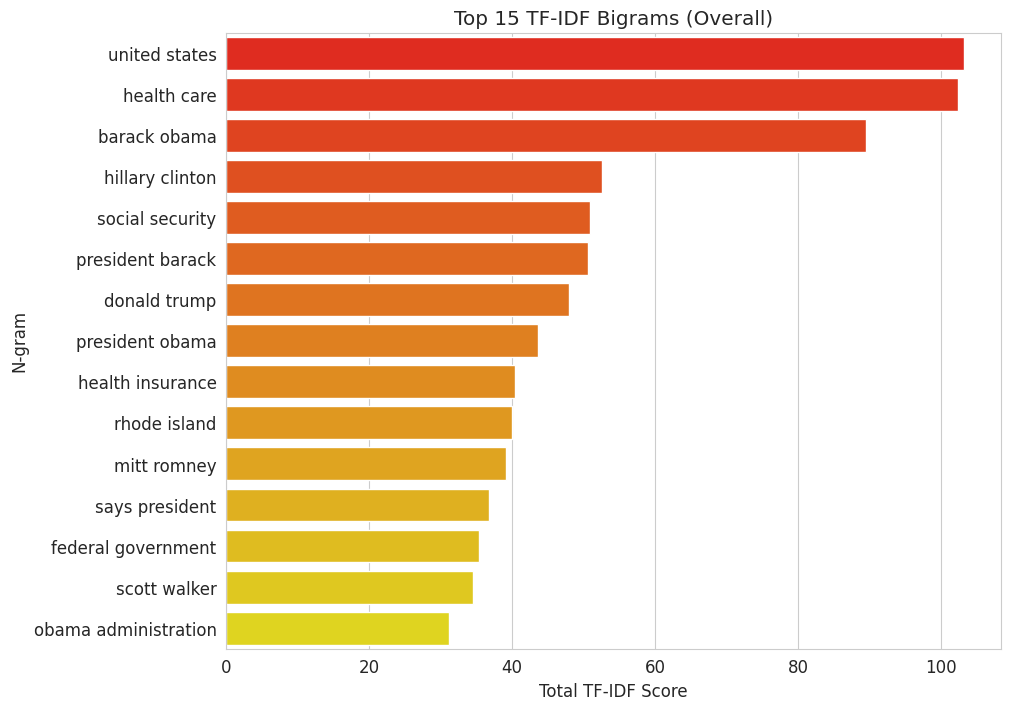

<ipython-input-57-0aaaa79173ca>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plt.figure(figsize=(10, 8)); sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_trigrams_overall, palette='winter'); plt.title('Top 15 TF-IDF Trigrams (Overall)'); plt.show()


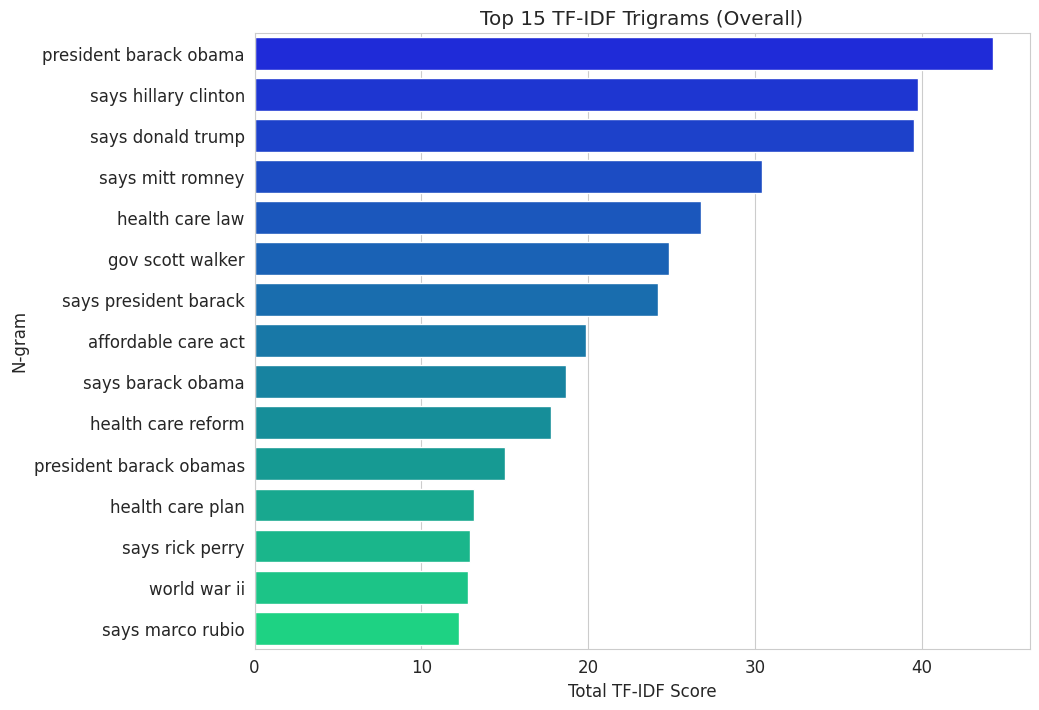


Per-Label TF-IDF N-gram Analysis (Top 5 per Label):

--- TF-IDF Unigrams for Label: pants-fire ---
      N-gram  Total TF-IDF Score
0       says           29.920080
1      obama           19.846823
2  president           14.391571
3     barack           12.536128
4     health           12.536007


<ipython-input-57-0aaaa79173ca>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_unigrams_label, palette='viridis', ax=axes_ug[plot_idx_ug])



--- TF-IDF Unigrams for Label: false ---
    N-gram  Total TF-IDF Score
0     says           62.636599
1  percent           30.898357
2    obama           30.615546
3    state           30.062473
4   health           27.841362


<ipython-input-57-0aaaa79173ca>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_unigrams_label, palette='viridis', ax=axes_ug[plot_idx_ug])



--- TF-IDF Unigrams for Label: barely-true ---
    N-gram  Total TF-IDF Score
0     says           55.797669
1  percent           29.620035
2    obama           25.204310
3    state           22.662378
4      tax           22.643682

--- TF-IDF Unigrams for Label: half-true ---


<ipython-input-57-0aaaa79173ca>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_unigrams_label, palette='viridis', ax=axes_ug[plot_idx_ug])


    N-gram  Total TF-IDF Score
0     says           64.602247
1  percent           49.890615
2    state           30.469050
3    obama           29.604032
4     jobs           29.138591


<ipython-input-57-0aaaa79173ca>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_unigrams_label, palette='viridis', ax=axes_ug[plot_idx_ug])



--- TF-IDF Unigrams for Label: mostly-true ---
    N-gram  Total TF-IDF Score
0     says           56.187683
1  percent           53.186997
2    state           29.992684
3      tax           29.420261
4    years           28.561459


<ipython-input-57-0aaaa79173ca>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_unigrams_label, palette='viridis', ax=axes_ug[plot_idx_ug])



--- TF-IDF Unigrams for Label: true ---
    N-gram  Total TF-IDF Score
0     says           47.591819
1  percent           42.536889
2    state           29.381742
3    years           24.012418
4     year           21.191543


<ipython-input-57-0aaaa79173ca>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_unigrams_label, palette='viridis', ax=axes_ug[plot_idx_ug])


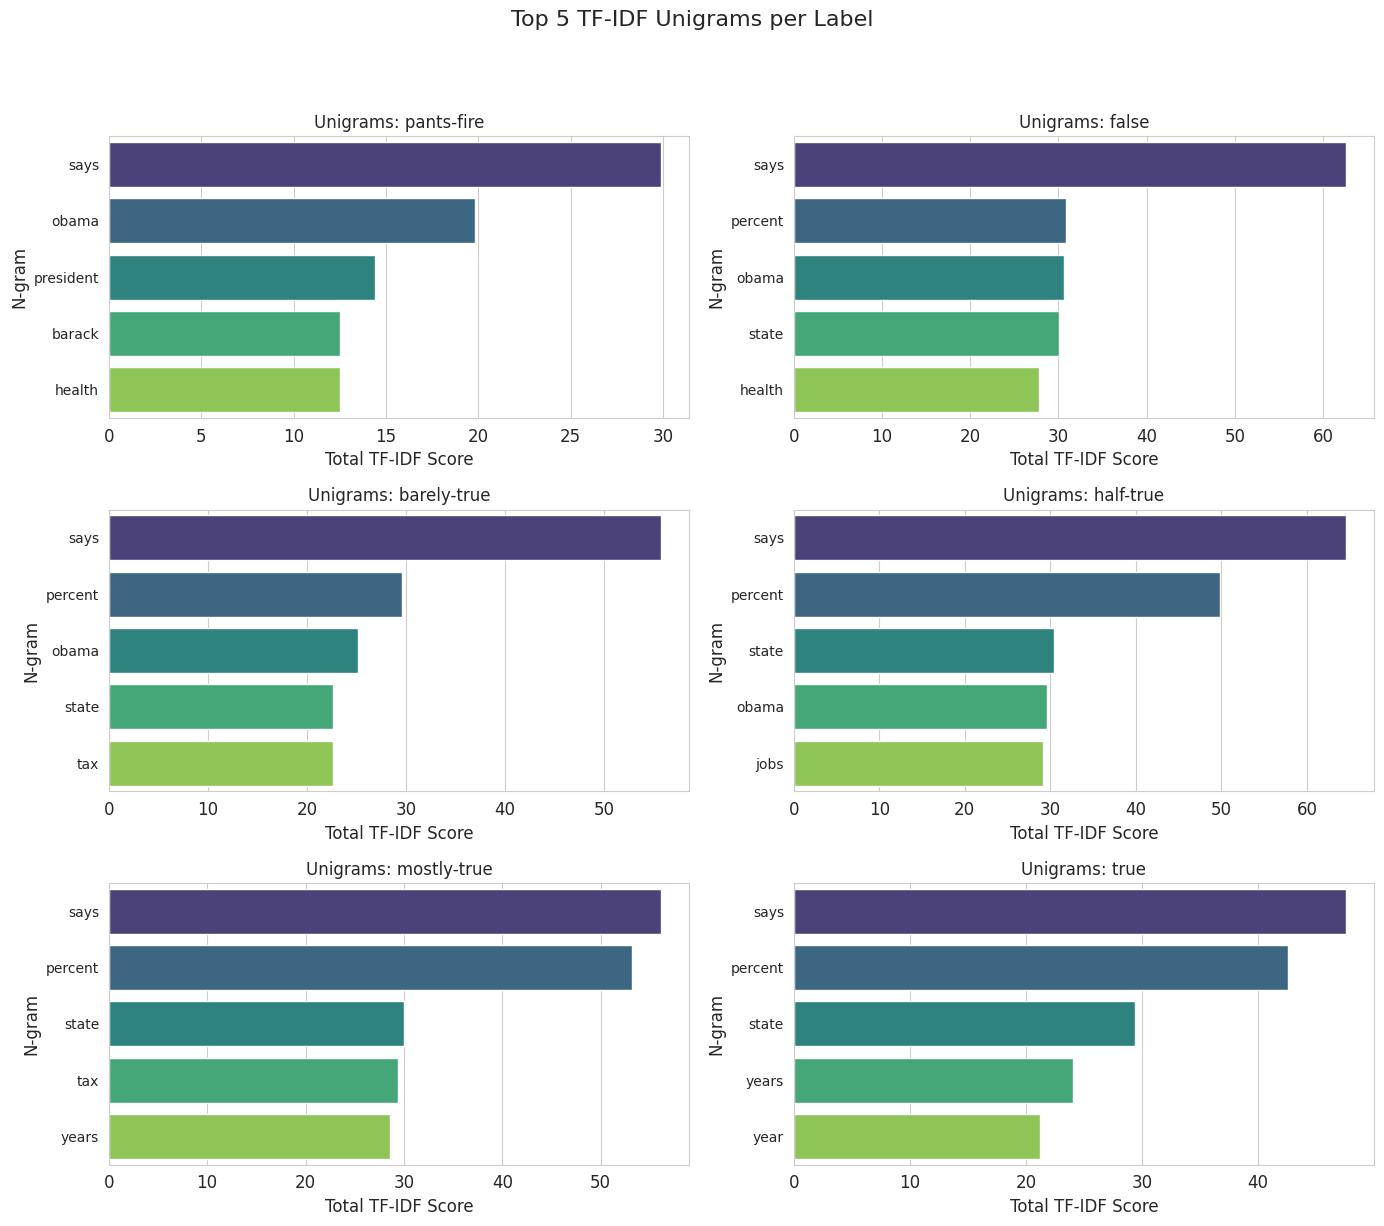

<ipython-input-57-0aaaa79173ca>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_bigrams_label, palette='coolwarm', ax=axes_bg[plot_idx_bg])
<ipython-input-57-0aaaa79173ca>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_bigrams_label, palette='coolwarm', ax=axes_bg[plot_idx_bg])
<ipython-input-57-0aaaa79173ca>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_bigrams_label, palette='cool

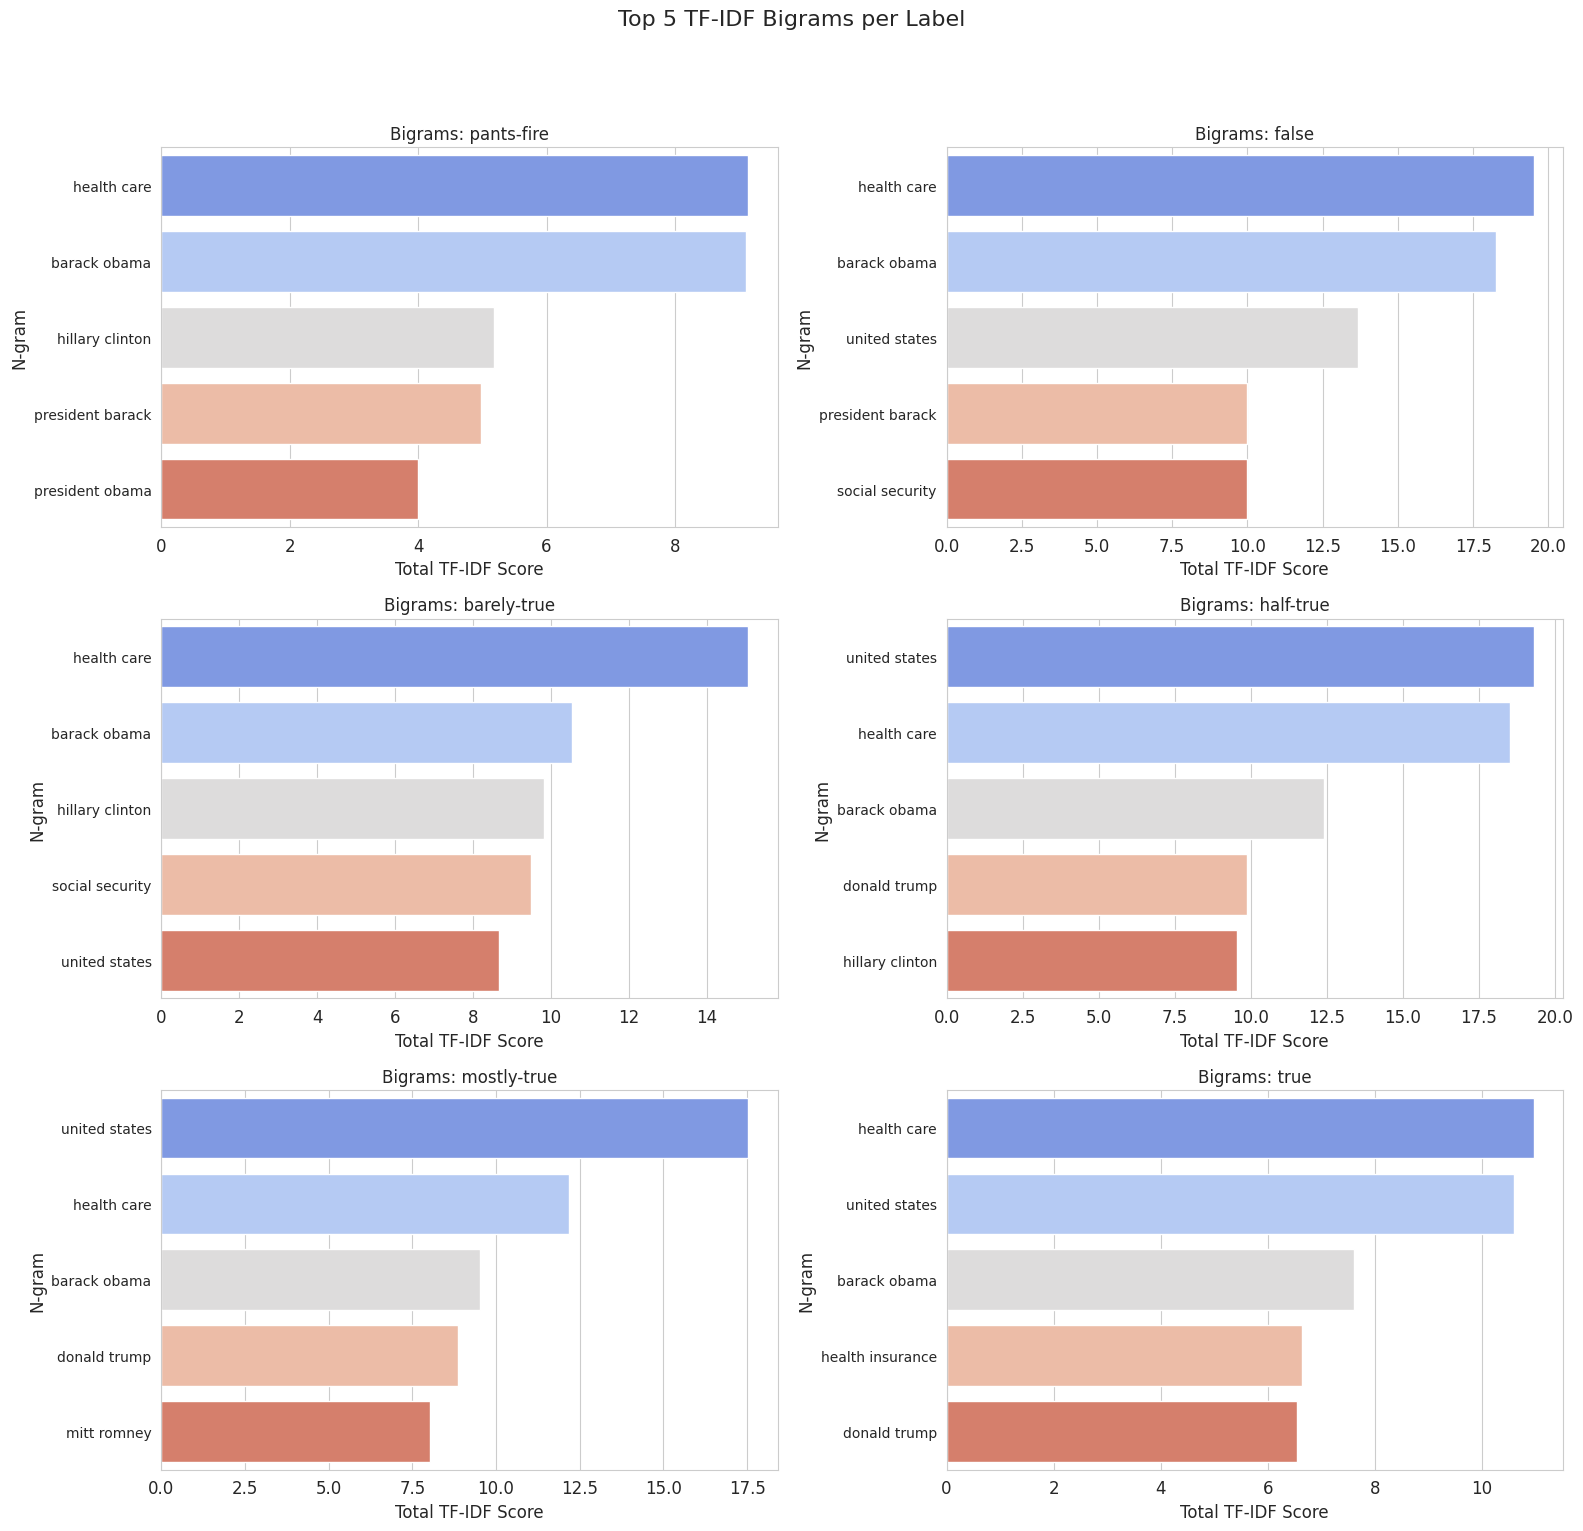


--- TF-IDF Trigrams for Label: pants-fire ---
                   N-gram  Total TF-IDF Score
0       says barack obama            4.015840
1  president barack obama            3.761057
2         health care law            3.588384
3        gov scott walker            2.703233
4    says hillary clinton            2.514409

--- TF-IDF Trigrams for Label: false ---
                   N-gram  Total TF-IDF Score
0  president barack obama            8.427397
1   says president barack            6.067581
2         health care law            5.563910
3        gov scott walker            5.283721
4    says hillary clinton            4.221370

--- TF-IDF Trigrams for Label: barely-true ---


<ipython-input-57-0aaaa79173ca>:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_trigrams_label, palette='cubehelix', ax=axes_tg[plot_idx_tg])
<ipython-input-57-0aaaa79173ca>:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_trigrams_label, palette='cubehelix', ax=axes_tg[plot_idx_tg])


                   N-gram  Total TF-IDF Score
0  president barack obama            5.753186
1    says hillary clinton            4.952840
2     affordable care act            3.581524
3       says donald trump            3.533872
4   says president barack            3.427111

--- TF-IDF Trigrams for Label: half-true ---
                   N-gram  Total TF-IDF Score
0  president barack obama            6.155725
1       says donald trump            6.094080
2    says hillary clinton            4.960072
3   says president barack            3.637728
4        says mitt romney            3.562505

--- TF-IDF Trigrams for Label: mostly-true ---


<ipython-input-57-0aaaa79173ca>:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_trigrams_label, palette='cubehelix', ax=axes_tg[plot_idx_tg])
<ipython-input-57-0aaaa79173ca>:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_trigrams_label, palette='cubehelix', ax=axes_tg[plot_idx_tg])


                   N-gram  Total TF-IDF Score
0       says donald trump            7.733957
1        says mitt romney            5.502594
2  president barack obama            5.261955
3    says hillary clinton            3.921572
4      corporate tax rate            3.235175

--- TF-IDF Trigrams for Label: true ---
                        N-gram  Total TF-IDF Score
0             says mitt romney            4.245354
1            says donald trump            3.899870
2       president barack obama            2.856291
3  romney flipflopped abortion            2.349557
4             health care plan            2.105964


<ipython-input-57-0aaaa79173ca>:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_trigrams_label, palette='cubehelix', ax=axes_tg[plot_idx_tg])
<ipython-input-57-0aaaa79173ca>:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_trigrams_label, palette='cubehelix', ax=axes_tg[plot_idx_tg])


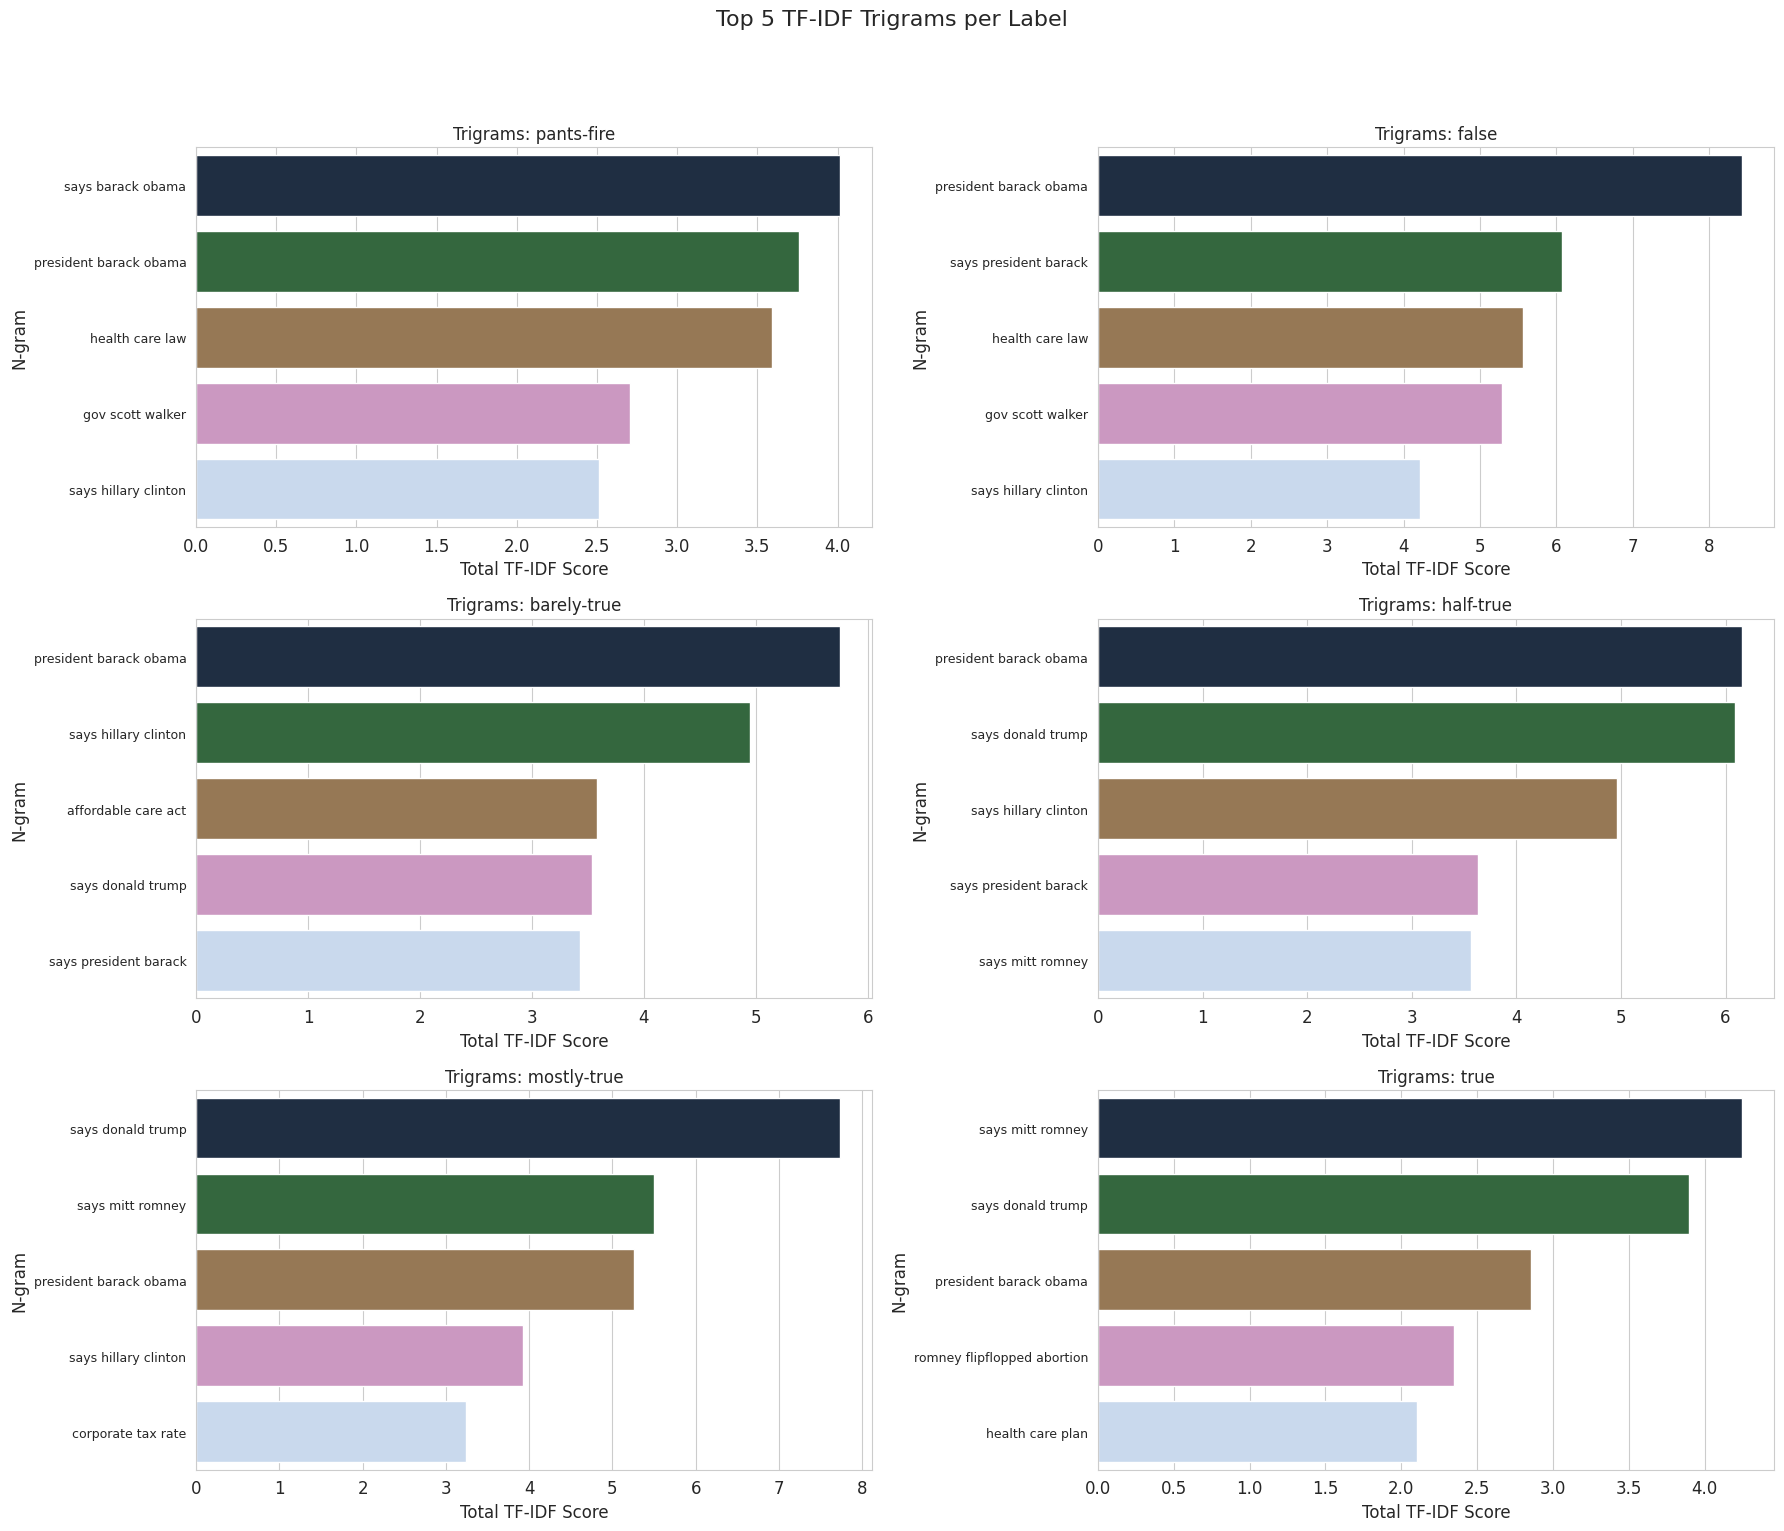

In [ ]:
# --- EDA Section 3: Advanced N-gram Analysis (TF-IDF) on Training Set ---
print("\n--- EDA Section 3: Advanced N-gram Analysis (TF-IDF) on Training Set ---")
corpus_tfidf = df['statement_cleaned_keep_stopwords'].dropna().tolist()
if corpus_tfidf:
    def get_top_tfidf_n_grams(corpus, ngram_range=(1,1), top_k=20):
        try:
            tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, stop_words='english', max_features=10000)
            tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
            if tfidf_matrix.shape[0] == 0 or tfidf_matrix.shape[1] == 0:
                # print(f"TF-IDF matrix is empty for ngram_range {ngram_range}.") # Less verbose
                return pd.DataFrame(columns=['N-gram', 'Total TF-IDF Score'])
            feature_names = tfidf_vectorizer.get_feature_names_out()
            sum_tfidf = tfidf_matrix.sum(axis=0)
            tfidf_scores = [(feature_names[col], sum_tfidf[0, col]) for col in range(sum_tfidf.shape[1])]
            sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
            top_n_grams_df = pd.DataFrame(sorted_tfidf_scores[:top_k], columns=['N-gram', 'Total TF-IDF Score'])
            return top_n_grams_df
        except Exception as e:
            # print(f"Error in TF-IDF N-gram generation ({ngram_range}): {e}") # Less verbose
            return pd.DataFrame(columns=['N-gram', 'Total TF-IDF Score'])

    # Overall TF-IDF N-grams
    top_tfidf_unigrams_overall = get_top_tfidf_n_grams(corpus_tfidf, ngram_range=(1,1), top_k=15)
    if not top_tfidf_unigrams_overall.empty:
        plt.figure(figsize=(10, 8)); sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_unigrams_overall, palette='summer'); plt.title('Top 15 TF-IDF Unigrams (Overall)'); plt.show()

    top_tfidf_bigrams_overall = get_top_tfidf_n_grams(corpus_tfidf, ngram_range=(2,2), top_k=15)
    if not top_tfidf_bigrams_overall.empty:
        plt.figure(figsize=(10, 8)); sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_bigrams_overall, palette='autumn'); plt.title('Top 15 TF-IDF Bigrams (Overall)'); plt.show()

    top_tfidf_trigrams_overall = get_top_tfidf_n_grams(corpus_tfidf, ngram_range=(3,3), top_k=15)
    if not top_tfidf_trigrams_overall.empty:
        plt.figure(figsize=(10, 8)); sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_trigrams_overall, palette='winter'); plt.title('Top 15 TF-IDF Trigrams (Overall)'); plt.show()


    # Per-Label TF-IDF N-grams (Unigrams, Bigrams, Trigrams in separate figures)
    print("\nPer-Label TF-IDF N-gram Analysis (Top 5 per Label):")

    # Setup for Unigram subplots
    labels_with_data_tfidf = [l for l in df['label'].cat.categories if not df[df['label'] == l].empty and l != 'Unknown']
    num_labels_tfidf = len(labels_with_data_tfidf)

    if num_labels_tfidf > 0:
        # Unigrams per label
        cols_subplot_ug = 2
        rows_subplot_ug = (num_labels_tfidf + cols_subplot_ug - 1) // cols_subplot_ug
        fig_ug, axes_ug = plt.subplots(rows_subplot_ug, cols_subplot_ug, figsize=(cols_subplot_ug*7, rows_subplot_ug*4), squeeze=False)
        axes_ug = axes_ug.ravel()
        plot_idx_ug = 0

        for label_val in labels_with_data_tfidf:
            print(f"\n--- TF-IDF Unigrams for Label: {label_val} ---")
            label_corpus_tfidf = df[df['label'] == label_val]['statement_cleaned_keep_stopwords'].dropna().tolist()
            if len(label_corpus_tfidf) > 1:
                top_tfidf_unigrams_label = get_top_tfidf_n_grams(label_corpus_tfidf, ngram_range=(1,1), top_k=5)
                if not top_tfidf_unigrams_label.empty:
                    print(top_tfidf_unigrams_label)
                    if plot_idx_ug < len(axes_ug):
                        sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_unigrams_label, palette='viridis', ax=axes_ug[plot_idx_ug])
                        axes_ug[plot_idx_ug].set_title(f'Unigrams: {label_val}', fontsize=12)
                        axes_ug[plot_idx_ug].tick_params(axis='y', labelsize=10)
                        plot_idx_ug += 1
                else:
                    print(f"Could not generate TF-IDF Unigrams for label: {label_val}.")
                    if plot_idx_ug < len(axes_ug): axes_ug[plot_idx_ug].axis('off'); plot_idx_ug +=1 # Hide empty subplot
            else:
                print(f"Not enough documents for TF-IDF unigram analysis for label: {label_val}")
                if plot_idx_ug < len(axes_ug): axes_ug[plot_idx_ug].axis('off'); plot_idx_ug +=1
        for i in range(plot_idx_ug, len(axes_ug)): fig_ug.delaxes(axes_ug[i]) # Hide unused
        fig_ug.suptitle('Top 5 TF-IDF Unigrams per Label', fontsize=16, y=1.02); plt.tight_layout(rect=[0,0,1,0.98]); plt.show()

        # Bigrams per label
        cols_subplot_bg = 2
        rows_subplot_bg = (num_labels_tfidf + cols_subplot_bg - 1) // cols_subplot_bg
        fig_bg, axes_bg = plt.subplots(rows_subplot_bg, cols_subplot_bg, figsize=(cols_subplot_bg*8, rows_subplot_bg*5), squeeze=False) # Slightly wider for bigrams
        axes_bg = axes_bg.ravel()
        plot_idx_bg = 0
        for label_val in labels_with_data_tfidf:
            # print(f"\n--- TF-IDF Bigrams for Label: {label_val} ---") # Already printed above for unigrams
            label_corpus_tfidf = df[df['label'] == label_val]['statement_cleaned_keep_stopwords'].dropna().tolist()
            if len(label_corpus_tfidf) > 1:
                top_tfidf_bigrams_label = get_top_tfidf_n_grams(label_corpus_tfidf, ngram_range=(2,2), top_k=5)
                if not top_tfidf_bigrams_label.empty:
                    # print(top_tfidf_bigrams_label) # Already printed in previous version
                    if plot_idx_bg < len(axes_bg):
                        sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_bigrams_label, palette='coolwarm', ax=axes_bg[plot_idx_bg])
                        axes_bg[plot_idx_bg].set_title(f'Bigrams: {label_val}', fontsize=12)
                        axes_bg[plot_idx_bg].tick_params(axis='y', labelsize=10)
                        plot_idx_bg += 1
                else:
                    # print(f"Could not generate TF-IDF Bigrams for label: {label_val}.")
                    if plot_idx_bg < len(axes_bg): axes_bg[plot_idx_bg].axis('off'); plot_idx_bg +=1
            else:
                # print(f"Not enough documents for TF-IDF bigram analysis for label: {label_val}")
                if plot_idx_bg < len(axes_bg): axes_bg[plot_idx_bg].axis('off'); plot_idx_bg +=1
        for i in range(plot_idx_bg, len(axes_bg)): fig_bg.delaxes(axes_bg[i])
        fig_bg.suptitle('Top 5 TF-IDF Bigrams per Label', fontsize=16, y=1.02); plt.tight_layout(rect=[0,0,1,0.98]); plt.show()

        # Trigrams per label
        cols_subplot_tg = 2
        rows_subplot_tg = (num_labels_tfidf + cols_subplot_tg - 1) // cols_subplot_tg
        fig_tg, axes_tg = plt.subplots(rows_subplot_tg, cols_subplot_tg, figsize=(cols_subplot_tg*9, rows_subplot_tg*5), squeeze=False) # Even wider for trigrams
        axes_tg = axes_tg.ravel()
        plot_idx_tg = 0
        for label_val in labels_with_data_tfidf:
            print(f"\n--- TF-IDF Trigrams for Label: {label_val} ---")
            label_corpus_tfidf = df[df['label'] == label_val]['statement_cleaned_keep_stopwords'].dropna().tolist()
            if len(label_corpus_tfidf) > 1:
                top_tfidf_trigrams_label = get_top_tfidf_n_grams(label_corpus_tfidf, ngram_range=(3,3), top_k=5)
                if not top_tfidf_trigrams_label.empty:
                    print(top_tfidf_trigrams_label)
                    if plot_idx_tg < len(axes_tg):
                        sns.barplot(x='Total TF-IDF Score', y='N-gram', data=top_tfidf_trigrams_label, palette='cubehelix', ax=axes_tg[plot_idx_tg])
                        axes_tg[plot_idx_tg].set_title(f'Trigrams: {label_val}', fontsize=12)
                        axes_tg[plot_idx_tg].tick_params(axis='y', labelsize=9) # Smaller font for potentially longer trigrams
                        plot_idx_tg += 1
                else:
                    print(f"Could not generate TF-IDF Trigrams for label: {label_val}.")
                    if plot_idx_tg < len(axes_tg): axes_tg[plot_idx_tg].axis('off'); plot_idx_tg +=1
            else:
                print(f"Not enough documents for TF-IDF trigram analysis for label: {label_val}")
                if plot_idx_tg < len(axes_tg): axes_tg[plot_idx_tg].axis('off'); plot_idx_tg +=1
        for i in range(plot_idx_tg, len(axes_tg)): fig_tg.delaxes(axes_tg[i])
        fig_tg.suptitle('Top 5 TF-IDF Trigrams per Label', fontsize=16, y=1.02); plt.tight_layout(rect=[0,0,1,0.98]); plt.show()
    else:
        print("Not enough labels with data for per-label TF-IDF analysis.")
else:
    print("Corpus for TF-IDF is empty. Skipping TF-IDF N-gram analysis.")


--- EDA Section 4: Topic Modeling (LDA) on Training Set ---

Top words for 5 discovered topics (LDA):
Topic #1: percent, says, billion, tax, taxes, state, federal, million, budget, wisconsin
Topic #2: says, public, spending, state, school, security, medicare, years, president, plan
Topic #3: people, health, care, country, says, percent, said, national, americans, vote
Topic #4: says, voted, clinton, state, republican, hillary, house, senate, campaign, money
Topic #5: states, obama, new, president, barack, jobs, united, million, years, times


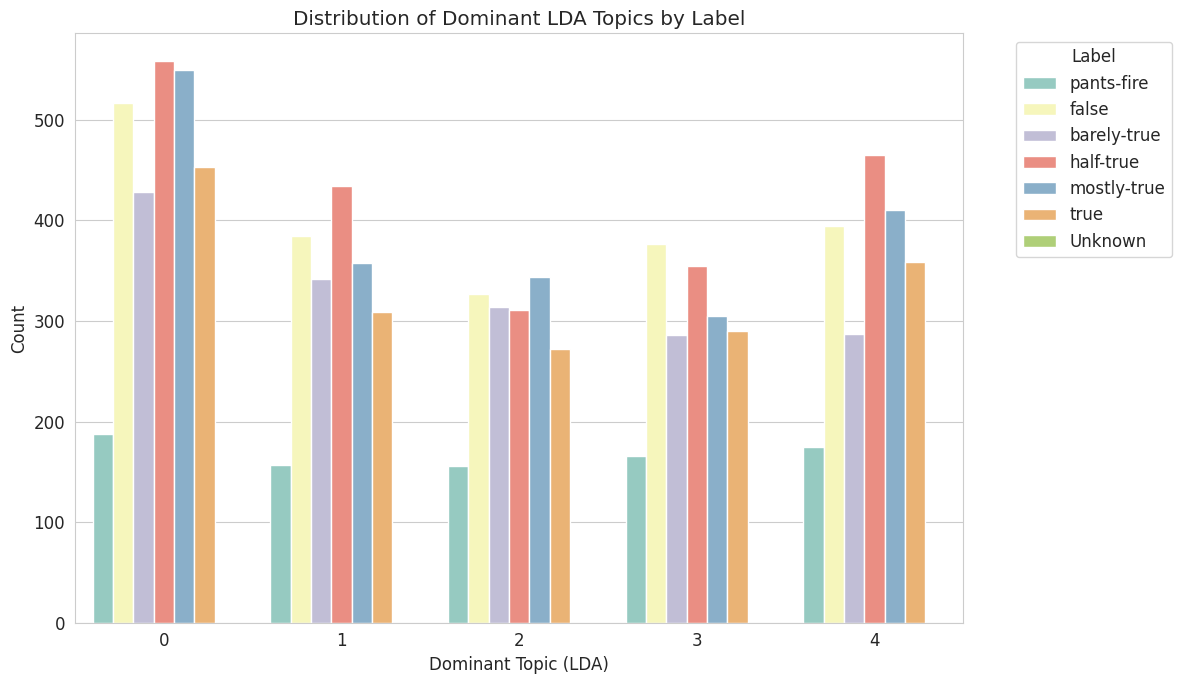

In [ ]:
# --- EDA Section 4: Topic Modeling (LDA) on Training Set ---
print("\n--- EDA Section 4: Topic Modeling (LDA) on Training Set ---")
if df.empty:
    print("Training DataFrame (df) is empty. Skipping Topic Modeling.")
else:
    corpus_lda = df['statement_cleaned_keep_stopwords'].dropna().tolist()
    if corpus_lda and len(corpus_lda) > 1:
        try:
            count_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=1000)
            doc_term_matrix = count_vectorizer.fit_transform(corpus_lda)
            if doc_term_matrix.shape[1] > 0:
                num_topics = 5
                lda = LatentDirichletAllocation(n_components=num_topics, random_state=42, learning_method='online')
                lda.fit(doc_term_matrix)
                print(f"\nTop words for {num_topics} discovered topics (LDA):")
                feature_names_lda = count_vectorizer.get_feature_names_out()
                for topic_idx, topic_dist in enumerate(lda.components_):
                    top_words_indices = topic_dist.argsort()[:-10 - 1:-1]
                    top_words = [feature_names_lda[i] for i in top_words_indices]
                    print(f"Topic #{topic_idx+1}: {', '.join(top_words)}")
                topic_results = lda.transform(doc_term_matrix)
                df['dominant_topic_lda'] = topic_results.argmax(axis=1)
                plt.figure(figsize=(12, 7))
                sns.countplot(x='dominant_topic_lda', hue='label', data=df, hue_order=label_order, palette='Set3')
                plt.title('Distribution of Dominant LDA Topics by Label'); plt.xlabel('Dominant Topic (LDA)'); plt.ylabel('Count')
                plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left'); plt.tight_layout(); plt.show()
            else:
                 print("Vocabulary is empty after CountVectorizer for LDA.")
        except Exception as e:
            print(f"Error during Topic Modeling: {e}")
    else:
        print("Corpus for LDA is too small or empty. Skipping Topic Modeling.")





--- EDA Section 5: Sentiment Analysis on Training Set ---


<ipython-input-12-7129cc204e3e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='compound', data=df, order=label_order, palette="PRGn")


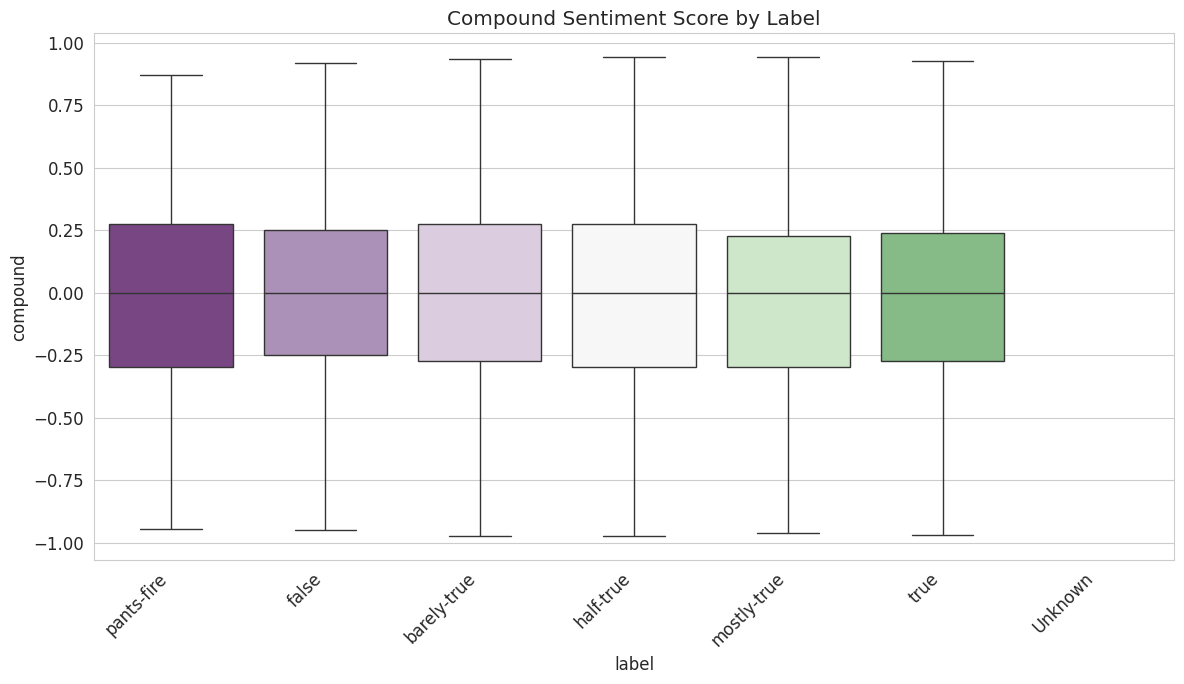

In [ ]:
# --- EDA Section 5: Sentiment Analysis on Training Set ---
print("\n--- EDA Section 5: Sentiment Analysis on Training Set ---")
if df.empty:
    print("Training DataFrame (df) is empty. Skipping Sentiment Analysis.")
else:
    try:
        sid = SentimentIntensityAnalyzer()
        def get_sentiment_scores(text):
            if not isinstance(text, str) or not text.strip():
                return {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
            return sid.polarity_scores(text)
        df['sentiment_scores'] = df['statement'].apply(get_sentiment_scores)
        df_sentiment = pd.json_normalize(df['sentiment_scores'])
        df = pd.concat([df, df_sentiment.reindex(df.index)], axis=1)

        plt.figure(figsize=(12, 7))
        sns.boxplot(x='label', y='compound', data=df, order=label_order, palette="PRGn")
        plt.title('Compound Sentiment Score by Label'); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"Error during Sentiment Analysis: {e}. NLTK VADER might not be set up correctly.")



--- EDA Section 6: Network Analysis (Speaker-Subject) on Training Set ---


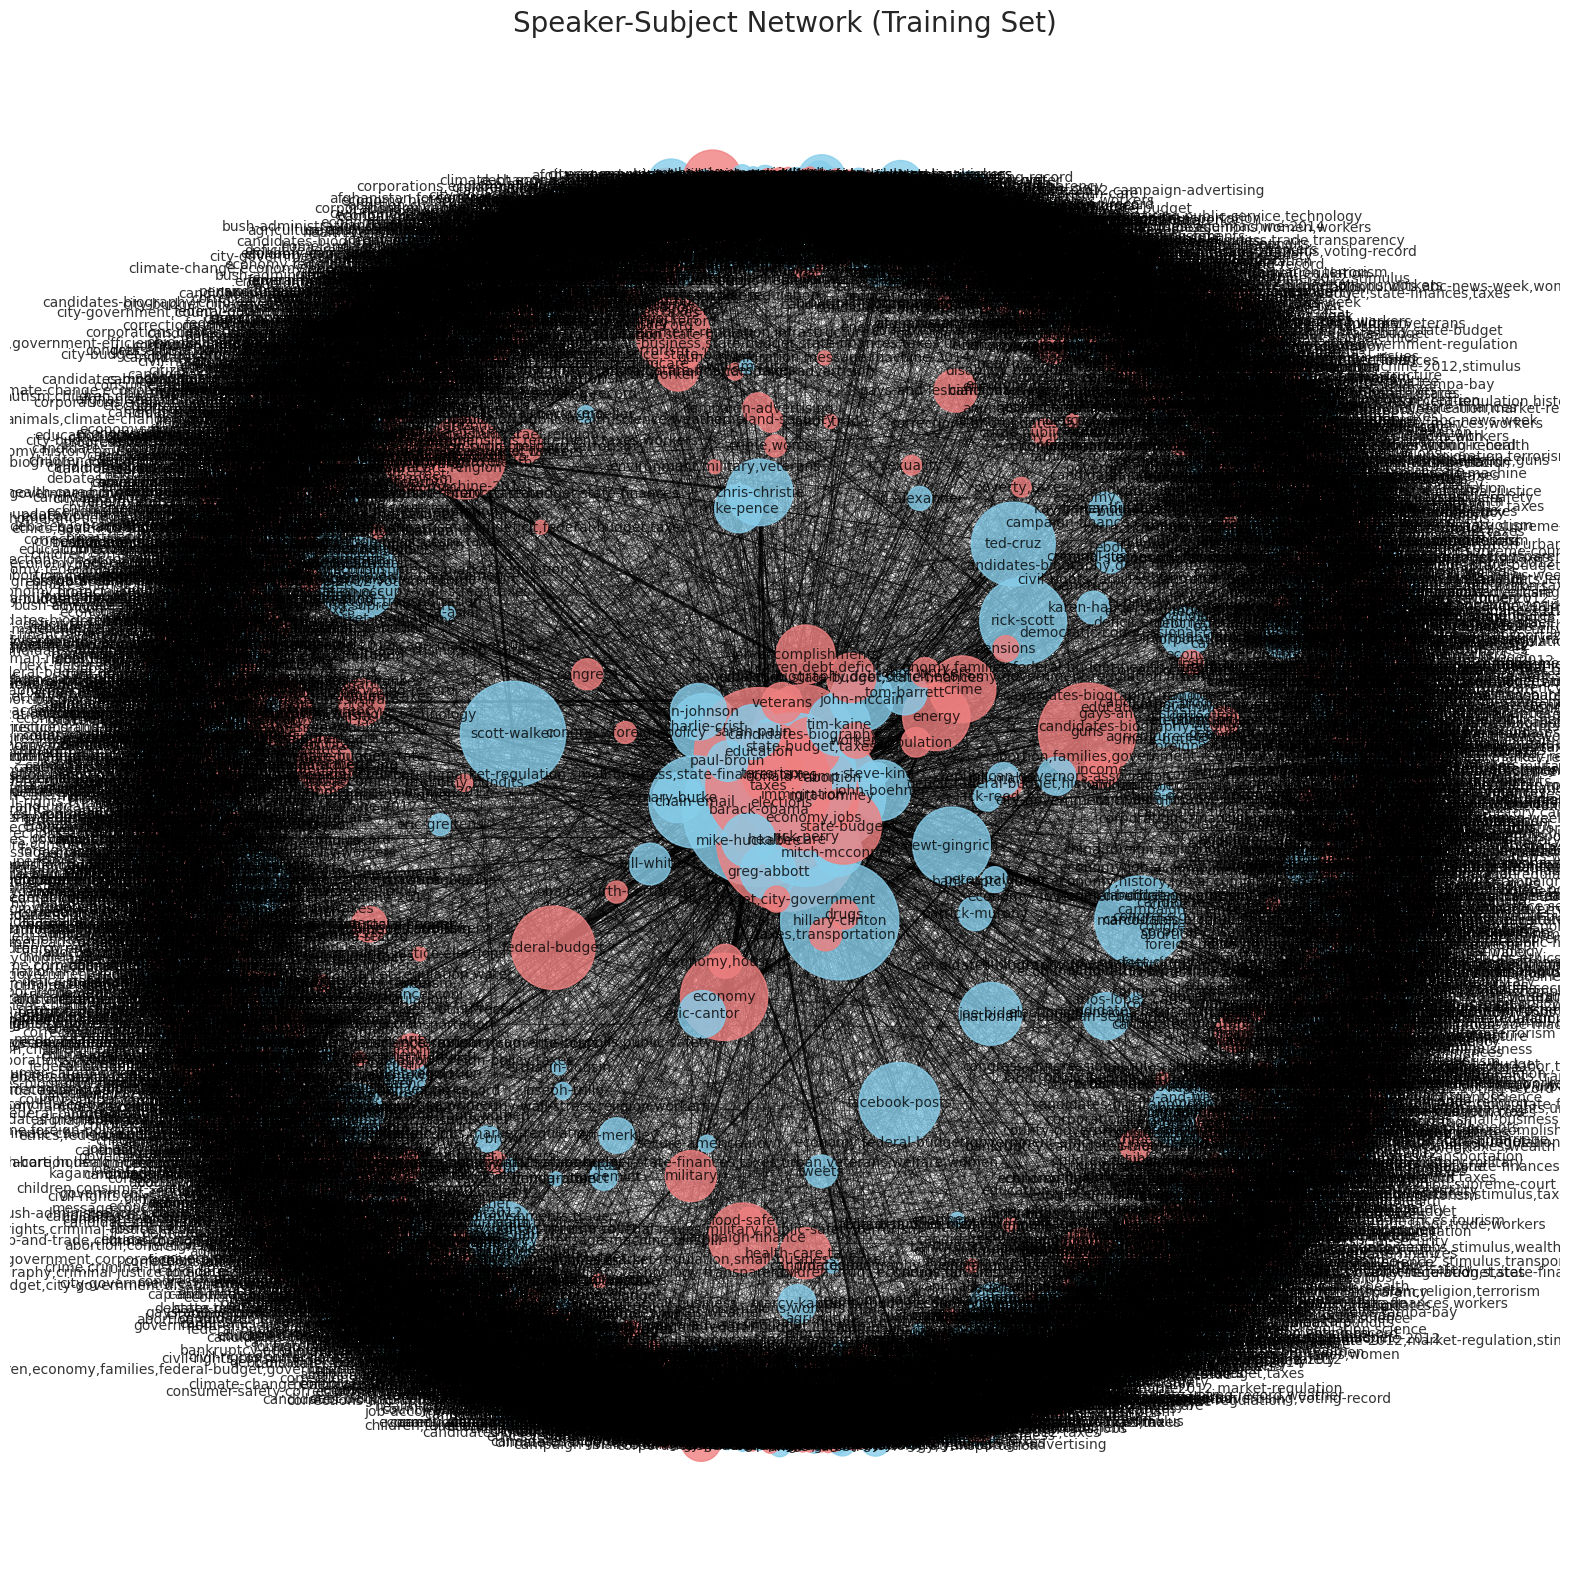


--- EDA Complete ---


In [ ]:
# --- EDA Section 6: Network Analysis (Speaker-Subject) on Training Set ---
print("\n--- EDA Section 6: Network Analysis (Speaker-Subject) on Training Set ---")
if df.empty:
    print("Training DataFrame (df) is empty. Skipping Network Analysis.")
elif 'speaker' not in df.columns or 'subject' not in df.columns:
    print("Skipping Network Analysis: 'speaker' or 'subject' column missing.")
else:
    speaker_subject_pairs = df[['speaker', 'subject']].dropna()
    speaker_subject_pairs = speaker_subject_pairs[ (speaker_subject_pairs['speaker'] != 'Unknown') & (speaker_subject_pairs['subject'] != 'Unknown') ]
    if not speaker_subject_pairs.empty:
        G = nx.Graph()
        for _, row in speaker_subject_pairs.iterrows():
            G.add_edge(row['speaker'], row['subject'], weight=G.get_edge_data(row['speaker'], row['subject'], {'weight': 0})['weight'] + 1)

        if G.number_of_nodes() > 0:
            plt.figure(figsize=(20, 20))
            degrees = dict(G.degree())
            node_sizes = [degrees.get(node, 0) * 50 + 50 for node in G.nodes()] if degrees else [50] * G.number_of_nodes()

            node_colors = []
            unique_speakers = df['speaker'].unique()
            unique_subjects = df['subject'].unique()
            for node in G.nodes():
                if node in unique_speakers: node_colors.append('skyblue')
                elif node in unique_subjects: node_colors.append('lightcoral')
                else: node_colors.append('lightgrey')

            pos = nx.spring_layout(G, k=0.75, iterations=50, seed=42)
            edge_widths = [G[u][v]['weight']*0.2 for u,v in G.edges()] if G.edges() else []

            nx.draw_networkx(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors,
                             font_size=10, alpha=0.8, width=edge_widths)
            plt.title('Speaker-Subject Network (Training Set)', fontsize=20)
            plt.axis('off'); plt.show()
    else:
        print("No valid speaker-subject pairs for network after filtering 'Unknown'.")

print("\n--- EDA Complete ---")

In [ ]:
from datasets import load_dataset
import pandas as pd

# Load the LIAR dataset from Hugging Face
dataset = load_dataset("liar")

# Convert to pandas DataFrame for better display
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# Print first 5 rows of Train dataset as table
print("=== Train Dataset Sample ===")
print(train_df.head().to_string(index=False))

# Print first 5 rows of Test dataset as table
print("\n=== Test Dataset Sample ===")
print(test_df.head().to_string(index=False))

# Export to CSV
train_df.to_csv("liar_train.csv", index=False)
test_df.to_csv("liar_test.csv", index=False)


=== Train Dataset Sample ===
        id  label                                                                                                                                     statement                            subject        speaker            job_title state_info party_affiliation  barely_true_counts  false_counts  half_true_counts  mostly_true_counts  pants_on_fire_counts             context
 2635.json      0                                                            Says the Annies List political group supports third-trimester abortions on demand.                           abortion   dwayne-bohac State representative      Texas        republican                 0.0           1.0               0.0                 0.0                   0.0            a mailer
10540.json      1 When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration. energy,history,job-accomplishments scott-surovell       State d

In [ ]:
dataset["train"]

Dataset({
    features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
    num_rows: 10269
})

In [ ]:
dataset["train"].take(5)

Dataset({
    features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
    num_rows: 5
})